# Payment Default Risk Prediction
**Author:** Mathias Gomez Chan  
**Date:** December 2025  
**Objective:** Build a logistic regression model to predict credit card payment defaults and optimize decision threshold for cost minimization.

---
## Table of Contents
1. [Business Problem](#business-problem)
2. [Data Overview](#data-overview)
3. [Exploratory Data Analysis](#exploratory-data-analysis)
4. [Feature Engineering](#feature-engineering)
5. [Modeling](#modeling)


---

## 1. Business Problem

**Business Context**
Financial institutions need to assess the risk of customers defaulting on payments. This model will help identify high-risk customers for proactive intervention.Leading decisions by balancing approval rates with risk exposure.
- The model Identifies high-risk customers before default occurs.
- Optimize decision based oon business cost (Quantifies potencial cost saving) 

**Success Metrics**
- Model performance: AUC-ROC, Precision, Recall
- Business impact: Cost reduction vs baseline strategy

---
## 2. Data Overview

**Dataset:** UCI Credit Card Default  
**Source:** https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset

**Time Period:** April 2005 to September 2005

**Observations:**  3000

**Variables:** 24 (Excluding ID)

### 2.1 Data Dictionary

| Variable | Description | Storage Type | Semantic Type | Values/Range |
|---------|-------------|--------------|---------------|--------------|
| **ID** | Unique client identifier | int64 | Identifier | 1 … N |
| **LIMIT_BAL** | Granted credit limit | int64 | Numerical | NT$ (continuous) |
| **SEX** | Gender | int64 | Categorical | 1=male, 2=female |
| **EDUCATION** | Highest education level | int64 | Categorical (ordinal) | 1=grad school, 2=university, 3=high school, 4=others, 5/6=unknown |
| **MARRIAGE** | Marital status | int64 | Categorical (nominal) | 1=married, 2=single, 3=others |
| **AGE** | Age in years | int64 | Numerical | Years (discrete) |
| **PAY_0** | Repayment status (Sept 2005) | int64 | Categorical (ordinal) | -2=no consumption, -1=paid in full, 0=revolving credit, 1=1-month delay, ..., 8=8-month delay|
| **PAY_2** | Repayment status (Aug 2005) | int64 | Categorical (ordinal) | Same as PAY_0 |
| **PAY_3** | Repayment status (Jul 2005) | int64 | Categorical (ordinal) | Same as PAY_0 |
| **PAY_4** | Repayment status (Jun 2005) | int64 | Categorical (ordinal) | Same as PAY_0 |
| **PAY_5** | Repayment status (May 2005) | int64 | Categorical (ordinal) | Same as PAY_0 |
| **PAY_6** | Repayment status (Apr 2005) | int64 | Categorical (ordinal) | Same as PAY_0 |
| **BILL_AMT1** | Bill statement (Sept 2005) | int64 | Numerical | NT$ (can be negative if overpayment) |
| **BILL_AMT2** | Bill statement (Aug 2005) | int64 | Numerical | NT$ |
| **BILL_AMT3** | Bill statement (Jul 2005) | int64 | Numerical | NT$ |
| **BILL_AMT4** | Bill statement (Jun 2005) | int64 | Numerical | NT$ |
| **BILL_AMT5** | Bill statement (May 2005) | int64 | Numerical | NT$ |
| **BILL_AMT6** | Bill statement (Apr 2005) | int64 | Numerical | NT$ |
| **PAY_AMT1** | Payment made (Sept 2005) | int64 | Numerical | NT$ |
| **PAY_AMT2** | Payment made (Aug 2005) | int64 | Numerical | NT$ |
| **PAY_AMT3** | Payment made (Jul 2005) | int64 | Numerical | NT$ |
| **PAY_AMT4** | Payment made (Jun 2005) | int64 | Numerical | NT$ |
| **PAY_AMT5** | Payment made (May 2005) | int64 | Numerical | NT$ |
| **PAY_AMT6** | Payment made (Apr 2005) | int64 | Numerical | NT$ |
| **default.payment.next.month** | Payment default in Oct 2005 | int64 | Categorical (binary) | 1=default, 0=no default |

- **For simplicity purposes we will not modify the Storage Type to fit the Semantic Type. This has no effects on our model**
- **Payment status columns (PAY_0-PAY_6) contain values outside the documented scale (-2 to 9). Investigation required in Section 2.3, additional context added by an user:** https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608

### 2.2 Feature Type Summary

**Numerical Features (14):**
- Credit limit: `LIMIT_BAL`
- Demographics: `AGE`
- Billing amounts: `BILL_AMT1` through `BILL_AMT6` (6 features)
- Payment amounts: `PAY_AMT1` through `PAY_AMT6` (6 features)

**Categorical Features (9):**
- Demographics: `SEX`, `EDUCATION`, `MARRIAGE` (3 features)
- Payment history: `PAY_0`, `PAY_2`, `PAY_3`, `PAY_4`, `PAY_5`, `PAY_6` (6 features)
  - **Note**: These are ordinal (ordered) categories representing delay severity

**Target Variable (1):**
- `default.payment.next.month` (binary: 0/1)

**Identifiers (1):**
- `ID` (will be dropped for modeling)

> **Modeling Decision**: Payment status variables (PAY_0-PAY_6) will be treated as ordinal integers in logistic regression, as the numeric encoding preserves meaningful order (higher values = more severe delays).

In [21]:
# =================================================================================================================================================================
# SECTION 2.3: DATASET STATISTICS
# =================================================================================================================================================================

# Libraries importation

## Mathematic and, Data Manipulation
import numpy as np
import pandas as pd

## Data Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import seaborn as sns

#Machine Learning and, Statistical Modeling
import sklearn
from sklearn.linear_model import LogisticRegression 
import scipy
from scipy import stats
import statsmodels
import statsmodels.api as sm


# Warnings
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv(r'C:\Users\mathi\OneDrive\Documentos\Data Science-LAPTOP-J1I19T3I-2\Python\Projects\data-science-portfolio\01-payment-default-prediction\data\raw\UCI_Credit_Card.csv')

print('='*60)
print('DATASET STATISTICS')
print('='*60)

# Basic dimensions
print(f'Total observations: {df.shape[0]:,}')
print(f'Total variables: {df.shape[1]-1} (excluding ID column)\n')

# Target variable distribution
print('='*60)
print('TARGET VARIABLE DISTRIBUTION')
print('='*60)
default_counts = df['default.payment.next.month'].value_counts().sort_index()
default_pcts = df['default.payment.next.month'].value_counts(normalize=True).sort_index()

print(f'NO DEFAULT DISTRIBUTION: {default_counts[0]:,} ({default_pcts[0]:.2%})')
print(f'DEFAULT DISTRIBUTION: {default_counts[1]:,} ({default_pcts[1]:.2%})')
    
# Missing values analysis
print('='*60)
print('DATA QUALITY CHECK')
print('='*60)
missing=df.isnull().sum()
if missing.sum() == 0:
    print('No missing values found')
else:
    print('Missing values found:', missing)
    
# Duplicate values analysis
duplicates = df.duplicated().sum()
print(f'Duplicated rows: {duplicates:,}')

# DataFrame header
print('='*60)
print('DATA HEADER (FIRST 5 ROWS)')
print('='*60)
df.head()

DATASET STATISTICS
Total observations: 30,000
Total variables: 24 (excluding ID column)

TARGET VARIABLE DISTRIBUTION
NO DEFAULT DISTRIBUTION: 23,364 (77.88%)
DEFAULT DISTRIBUTION: 6,636 (22.12%)
DATA QUALITY CHECK
No missing values found
Duplicated rows: 0
DATA HEADER (FIRST 5 ROWS)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [22]:
# =================================================================================================================================================================
# SECTION 2.3.1: DATASET STATISTICS/PAYMENT STATUS VALUES VERIFICATION
# =================================================================================================================================================================

# Verification of payment status values
print('='*60)
print('PAYMENT STATUS VALUES VERIFICATION')
print('='*60)

pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

print("\nUnique values in payment status columns:")
for col in pay_cols:
    print(f"\n{col}: {sorted(df[col].unique())}")

# Analyze frequency of payment status values
print("\n" + "="*60)
print("PAYMENT STATUS VALUE DISTRIBUTIONS")
print("="*60)

for col in pay_cols:
    print(f"\n{col}:")
    value_counts = df[col].value_counts().sort_index()
    for value, count in value_counts.items():
        pct = (count / len(df)) * 100
        print(f"  {value:2d}: {count:6,} ({pct:5.2f}%)")

PAYMENT STATUS VALUES VERIFICATION

Unique values in payment status columns:

PAY_0: [np.int64(-2), np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]

PAY_2: [np.int64(-2), np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]

PAY_3: [np.int64(-2), np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]

PAY_4: [np.int64(-2), np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]

PAY_5: [np.int64(-2), np.int64(-1), np.int64(0), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]

PAY_6: [np.int64(-2), np.int64(-1), np.int64(0), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]

PAYMENT STATUS VALUE DIS

### 2.3 Initial findings
 **Dataset Size**: 30,000 customers with 24 variables (Excluding ID)

- **Target Variable**: 22.12% default rate (6,636 defaults / 23,364 non defaults) 
    - **Class imbalance**: The Dataset has ~3.5:1 ratio of non defaults to default cases. This is manageable but monitored in the logistic regression model, it will be reviewed during the Model Evauluation. The more important metrics in this case are precision/recall, more important than accuaracy


**Payment Status analysis
  - **Value Verification**: All values within expected range [-2, 8].
  - **Value Frequency Pattern**: Most customers fall into categories -1 (paid in full), 0 (revolving credit), or 1-2 month delays. Values -2 (no consumption) and extreme delays (6-8 months) are rare. No data cleaning required for payment status variables.

**Data Quality**: 
 - No missing values
 - No duplicate records
 - All features have valid integer encodings



## 3. Exploratory Data Analysis

### 3.1 Feature Importance Screening
**Objective**: Rank 23 features by statistical association with default status using appropiate hypothesis test for continuous and categorical variables.

**Continuous Features (n=14):**
- **Test:** Mann-Whitney U test (non-parametric, robust to skewness)
- **Effect Size:** Point-biserial correlation and Cohen's d
- **Rationale:** Credit data typically exhibits non-normal distributions

**Categorical Features (n=9):**
- **Test:** Chi-square test of independence
- **Effect Size:** Cramér's V
- **Rationale:** Standard method for categorical-binary associations

**Significance Level:** α = 0.05 (two-tailed)

In [23]:
# =================================================================================================================================================================
# ANALYSIS FRAMEWORK / FEATURE IMPORTANCE
# =================================================================================================================================================================

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10,6)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print('='*60)
print('SECTION 3.1: FEATURE IMPORTANCE SCREENING')
print('='*60)

# Target distribution analysis
print(f"\nDefault Rate: {df['default.payment.next.month'].mean():.2%}")
print(f"Class Distribution:\n{df['default.payment.next.month'].value_counts(normalize=True)}")

## Target variable binary check
assert df['default.payment.next.month'].isin([0, 1]).all(), "Target must be binary"
print("\n Positive Data validation")


SECTION 3.1: FEATURE IMPORTANCE SCREENING

Default Rate: 22.12%
Class Distribution:
default.payment.next.month
0    0.7788
1    0.2212
Name: proportion, dtype: float64

 Positive Data validation


In [24]:
# =================================================================================================================================================================
# FEATURE CLASSIFICATION
# =================================================================================================================================================================

# Defining feature groups base on their data types:

continuous_features= ['LIMIT_BAL', 'AGE','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

categorical_features = [ 'SEX', 'EDUCATION', 'MARRIAGE','PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Target variable
target = 'default.payment.next.month'

print(f"\nContinuous features: {len(continuous_features)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"Total features to analyze: {len(continuous_features) + len(categorical_features)}")




Continuous features: 14
Categorical features: 9
Total features to analyze: 23


In [25]:
# =================================================================================================================================================================
# CONTINUOUS FEATURE ANALYSIS
# =================================================================================================================================================================

from scipy.stats import mannwhitneyu, pointbiserialr
from scipy.stats import chi2_contingency
import numpy as np

print("\n" + "="*60)
print("MANN-WHITNEY U TEST: CONTINUOUS FEATURES")
print("="*60)

continuous_results = []

for feature in continuous_features:
    group_0 = df[df[target] == 0][feature]
    group_1 = df[df[target] == 1][feature]

    # Perform Mann-Whitney U Test
    statistic, p_value = mannwhitneyu(group_0, group_1, alternative ='two-sided')
    
    # Point-biserial correlation (effect size)
    r_pb, _ = pointbiserialr(df[target], df[feature])

    # Cohen's d (standarized mean difference)
    mean_0, mean_1 = group_0.mean(), group_1.mean()
    std_pooled = np.sqrt(((len(group_0) - 1) * group_0.std()**2 + (len(group_1) - 1) * group_1.std()**2) / (len(group_0) + len(group_1)) - 2)
    cohens_d = (mean_1 - mean_0) / std_pooled
    
    continuous_results.append({
        'Feature': feature,
        'U-Statistic': statistic,
        'p-value': p_value,
        'Point-Biserial r': r_pb,
        'Cohen\'s d': cohens_d,
        'Mean (No Default)': mean_0,
        'Mean (Default)': mean_1
    })

# Create results dataframe
continuous_df = pd.DataFrame(continuous_results)
continuous_df['Significant'] = continuous_df['p-value'] < 0.05
continuous_df = continuous_df.sort_values('p-value')

print("\nTop 10 Most Significant Continuous Features:")
print(continuous_df[['Feature', 'p-value', 'Point-Biserial r', 'Cohen\'s d', 'Significant']].head(10))


MANN-WHITNEY U TEST: CONTINUOUS FEATURES

Top 10 Most Significant Continuous Features:
      Feature      p-value  Point-Biserial r  Cohen's d  Significant
0   LIMIT_BAL  1.2255e-189           -0.1535    -0.3743         True
8    PAY_AMT1  4.6167e-170           -0.0729    -0.1762         True
9    PAY_AMT2  9.9550e-151           -0.0586    -0.1414         True
10   PAY_AMT3  8.9927e-129           -0.0563    -0.1357         True
11   PAY_AMT4  7.2847e-109           -0.0568    -0.1371         True
13   PAY_AMT6   3.1841e-98           -0.0532    -0.1283         True
12   PAY_AMT5   1.1249e-90           -0.0551    -0.1330         True
2   BILL_AMT1   1.1510e-05           -0.0196    -0.0473         True
3   BILL_AMT2   7.0612e-03           -0.0142    -0.0342         True
4   BILL_AMT3   2.8203e-02           -0.0141    -0.0339         True


In [26]:
# =================================================================================================================================================================
# CATEGORICAL FEATURE ANALYSIS
# =================================================================================================================================================================

from scipy.stats import mannwhitneyu, pointbiserialr
from scipy.stats import chi2_contingency
import numpy as np

print("\n" + "="*60)
print("CHI-SQUARE TEST: CATEGORICAL FEATURES")
print("="*60)

categorical_results = []

for feature in categorical_features:
    # Create contingency table
    contingency_table = pd.crosstab(df[feature], df[target])
    
    # Chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Cramér's V (effect size)
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim))
    
    categorical_results.append({
        'Feature': feature,
        'Chi2-Statistic': chi2,
        'p-value': p_value,
        'Cramér\'s V': cramers_v,
        'df': dof
    })

# Create results dataframe
categorical_df = pd.DataFrame(categorical_results)
categorical_df['Significant'] = categorical_df['p-value'] < 0.05
categorical_df = categorical_df.sort_values('p-value')

print("\nCategorical Features Results:")
print(categorical_df[['Feature', 'p-value', 'Cramér\'s V', 'Significant']])


CHI-SQUARE TEST: CATEGORICAL FEATURES

Categorical Features Results:
     Feature     p-value  Cramér's V  Significant
3      PAY_0  0.0000e+00      0.4229         True
6      PAY_4  0.0000e+00      0.2794         True
5      PAY_3  0.0000e+00      0.2957         True
4      PAY_2  0.0000e+00      0.3403         True
7      PAY_5  0.0000e+00      0.2707         True
8      PAY_6  0.0000e+00      0.2508         True
1  EDUCATION  1.2333e-32      0.0738         True
0        SEX  4.9447e-12      0.0399         True
2   MARRIAGE  8.8259e-08      0.0345         True


In [27]:
# =================================================================================================================================================================
# COMBINING FEATURE IMPORTANCE RANKING
# =================================================================================================================================================================

print("\n" + "="*60)
print("TOP FEATURES BY STATISTICAL SIGNIFICANCE")
print("="*60)

# Combine both result sets
continuous_ranked = continuous_df[['Feature', 'p-value', 'Point-Biserial r']].copy()
continuous_ranked['Type'] = 'Continuous'
continuous_ranked['Effect Size'] = continuous_ranked['Point-Biserial r'].abs()

categorical_ranked = categorical_df[['Feature', 'p-value', 'Cramér\'s V']].copy()
categorical_ranked['Type'] = 'Categorical'
categorical_ranked['Effect Size'] = categorical_ranked['Cramér\'s V']

# Combine and rank
all_features = pd.concat([
    continuous_ranked[['Feature', 'Type', 'p-value', 'Effect Size']],
    categorical_ranked[['Feature', 'Type', 'p-value', 'Effect Size']]
]).sort_values('p-value')

print("\nTop 10 Most Predictive Features:")
print(all_features.head(10).to_string(index=False))

# Identify top 7 for detailed EDA
top_7_features = all_features.head(7)['Feature'].tolist()
print(f"\n{'='*60}")
print(f"FEATURES SELECTED FOR DETAILED EDA (Top 7):")
print(f"{'='*60}")
for i, feature in enumerate(top_7_features, 1):
    print(f"{i}. {feature}")


TOP FEATURES BY STATISTICAL SIGNIFICANCE

Top 10 Most Predictive Features:
  Feature        Type     p-value  Effect Size
    PAY_4 Categorical  0.0000e+00       0.2794
    PAY_0 Categorical  0.0000e+00       0.4229
    PAY_2 Categorical  0.0000e+00       0.3403
    PAY_3 Categorical  0.0000e+00       0.2957
    PAY_6 Categorical  0.0000e+00       0.2508
    PAY_5 Categorical  0.0000e+00       0.2707
LIMIT_BAL  Continuous 1.2255e-189       0.1535
 PAY_AMT1  Continuous 4.6167e-170       0.0729
 PAY_AMT2  Continuous 9.9550e-151       0.0586
 PAY_AMT3  Continuous 8.9927e-129       0.0563

FEATURES SELECTED FOR DETAILED EDA (Top 7):
1. PAY_4
2. PAY_0
3. PAY_2
4. PAY_3
5. PAY_6
6. PAY_5
7. LIMIT_BAL


### 3.1 Key Findings

**Statistical Testing Summary**:
- **Continuous Features**: Mann-Whitney U test with point-biserial correlation
- **Categorical Features**: Chi-square test with Cramér's V
- **Significance Level**: α = 0.05 (all top features: p < 0.001)

**Top 7 Features Selected for Detailed EDA**:

| Rank | Feature | Type | Effect Size | Interpretation |
|------|---------|------|-------------|----------------|
| 1 | PAY_0 | Categorical | V = 0.42 | Recent payment status (Sept) - **strongest predictor** |
| 2 | PAY_2 | Categorical | V = 0.34 | Payment status 2 months ago (Aug) |
| 3 | PAY_3 | Categorical | V = 0.30 | Payment status 3 months ago (Jul) |
| 4 | PAY_4 | Categorical | V = 0.28 | Payment status 4 months ago (Jun) |
| 5 | PAY_5 | Categorical | V = 0.27 | Payment status 5 months ago (May) |
| 6 | PAY_6 | Categorical | V = 0.25 | Payment status 6 months ago (Apr) |
| 7 | LIMIT_BAL | Continuous | r = -0.15 | Credit limit (negative correlation with default) |

- **Critical Insight**: Payment history variables (PAY_0-PAY_6) completely dominate feature importance. The temporal pattern shows recency matters - PAY_0 (most recent) has the strongest effect, with declining importance for older months. This suggests logistic regression should strongly weight recent payment behavior.

- **Modeling Implication**: The top 7 features will be prioritized in visualizations and may be sufficient for a parsimonious model. Demographics (SEX, EDUCATION, MARRIAGE) showed statistical significance but negligible practical effect sizes (V < 0.08).

---

### 3.2 Feature Visualization

**Objective**: Visualize the main 7 features and, show preliminary tendencies that might lead to the best fit to the model. 

**Continuous features (n=1)**: LIMIT_BAL

- Only one continuous variable was choosed from the top 7 previously sorted, which is the less significant.

- Considering one important hipothesis, that the relation from the credit limit is inverse with default rate.

- Visualization method: Box Plot, is used to present the relation between the Limnit credit (LIMIT_BAL) and, the default rate.

**Main Categorical features (n=6)**: PAY_0...PAY_6 

- The categorical features for payment status are the most signinficantly correlated with the Target Variable.

- Visualization method: Barplot, is used to present a compelling idea on how these features are correlated among themselves and, with the target variable. Also, if the default rate has a high deviation among category features.

In [28]:
# =================================================================================================================================================================
# CATEGORICAL FEATURES VISUALIZATIONS
# =================================================================================================================================================================

# Create a function to plot the required PAY status.

def plot_pay_status(pay_column):
    """
    Create bar plot showing default rate by payment status category.
    
    Parameters:
    -----------
    pay_column : str
        Column name for payment status (e.g., 'PAY_0', 'PAY_2')
    """    
    pay_default_rate = df.groupby(pay_column)['default.payment.next.month'].agg(['mean', 'count'])
    pay_default_rate['Percentage']= (pay_default_rate['mean'] * 100).round()

    # Create bar plot
    fig,ax = plt.subplots(figsize=(10,6))
    ax=sns.barplot(x=pay_default_rate.index, y=pay_default_rate['Percentage'])

    # Add sample size labels above bars
    for i, (idx, row) in enumerate(pay_default_rate.iterrows()):
        ax.text(i, row['Percentage'] + 1, f"n={row['count']:,}", 
                ha='center', fontsize=9, fontweight='bold')

    # Labels and formatting
    plt.title(f'Default Rate by Most Recent Payment Status ({pay_column})', fontsize= 14, fontweight='bold')
    plt.xlabel('{} Status (-2=no consumption, -1=paid in full, 0=revolving, 1+=months delayed)'.format(pay_column), fontsize=11)
    plt.ylabel('Default Rate (%)', fontsize=11)
    plt.ylim(0, max(pay_default_rate['Percentage']) + 10)  # Add space for labels
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n{} Default Rate Summary:".format(pay_column))
    print(pay_default_rate)

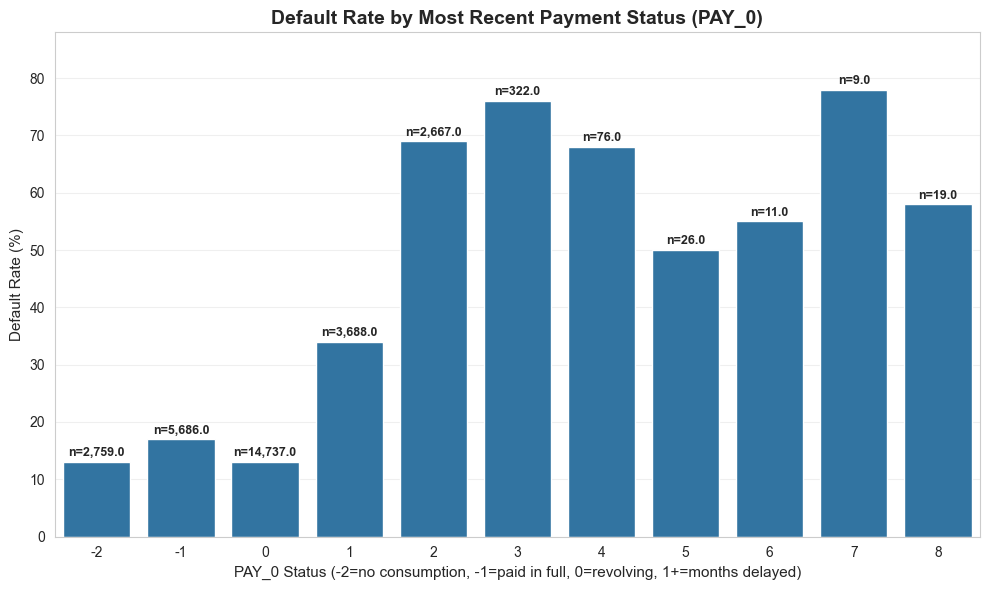


PAY_0 Default Rate Summary:
         mean  count  Percentage
PAY_0                           
-2     0.1323   2759        13.0
-1     0.1678   5686        17.0
 0     0.1281  14737        13.0
 1     0.3395   3688        34.0
 2     0.6914   2667        69.0
 3     0.7578    322        76.0
 4     0.6842     76        68.0
 5     0.5000     26        50.0
 6     0.5455     11        55.0
 7     0.7778      9        78.0
 8     0.5789     19        58.0


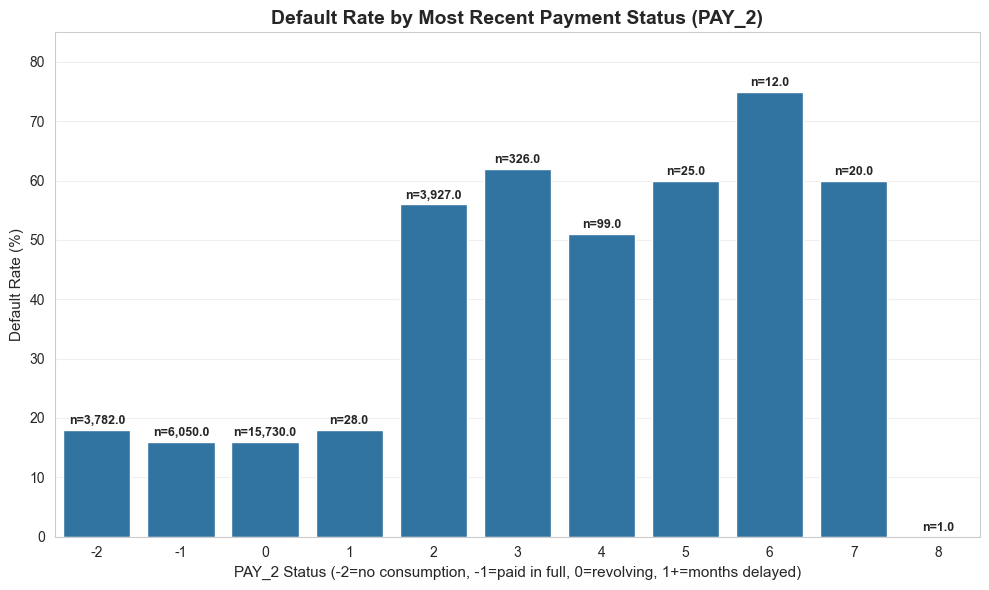


PAY_2 Default Rate Summary:
         mean  count  Percentage
PAY_2                           
-2     0.1827   3782        18.0
-1     0.1597   6050        16.0
 0     0.1591  15730        16.0
 1     0.1786     28        18.0
 2     0.5561   3927        56.0
 3     0.6166    326        62.0
 4     0.5051     99        51.0
 5     0.6000     25        60.0
 6     0.7500     12        75.0
 7     0.6000     20        60.0
 8     0.0000      1         0.0


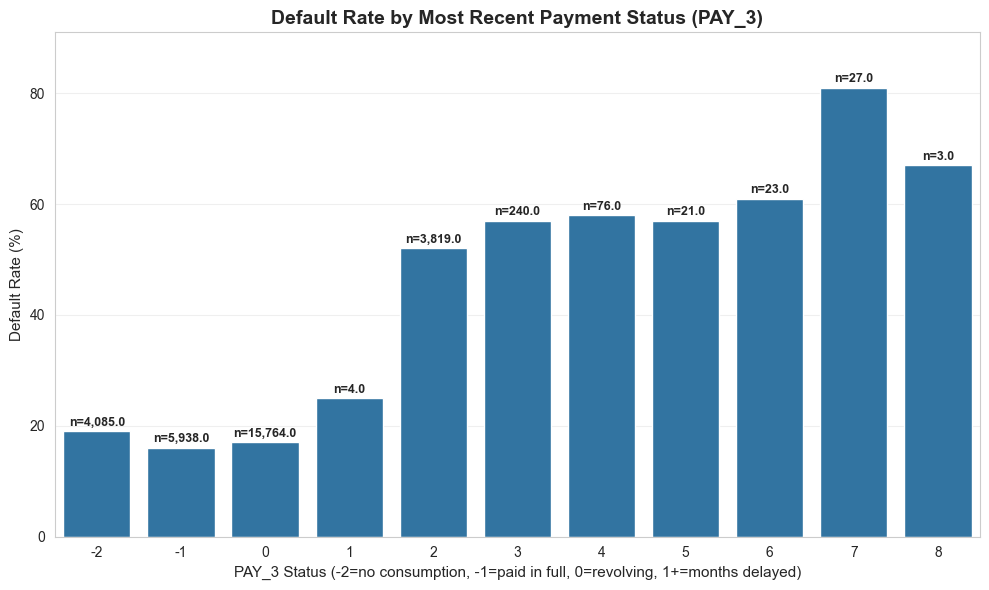


PAY_3 Default Rate Summary:
         mean  count  Percentage
PAY_3                           
-2     0.1853   4085        19.0
-1     0.1559   5938        16.0
 0     0.1745  15764        17.0
 1     0.2500      4        25.0
 2     0.5156   3819        52.0
 3     0.5750    240        57.0
 4     0.5789     76        58.0
 5     0.5714     21        57.0
 6     0.6087     23        61.0
 7     0.8148     27        81.0
 8     0.6667      3        67.0


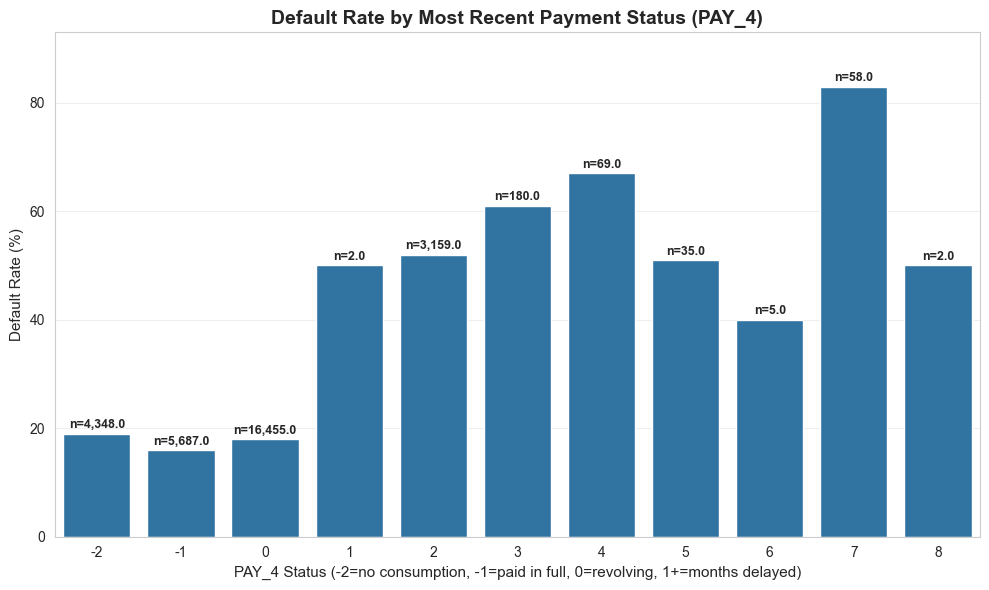


PAY_4 Default Rate Summary:
         mean  count  Percentage
PAY_4                           
-2     0.1925   4348        19.0
-1     0.1590   5687        16.0
 0     0.1833  16455        18.0
 1     0.5000      2        50.0
 2     0.5233   3159        52.0
 3     0.6111    180        61.0
 4     0.6667     69        67.0
 5     0.5143     35        51.0
 6     0.4000      5        40.0
 7     0.8276     58        83.0
 8     0.5000      2        50.0


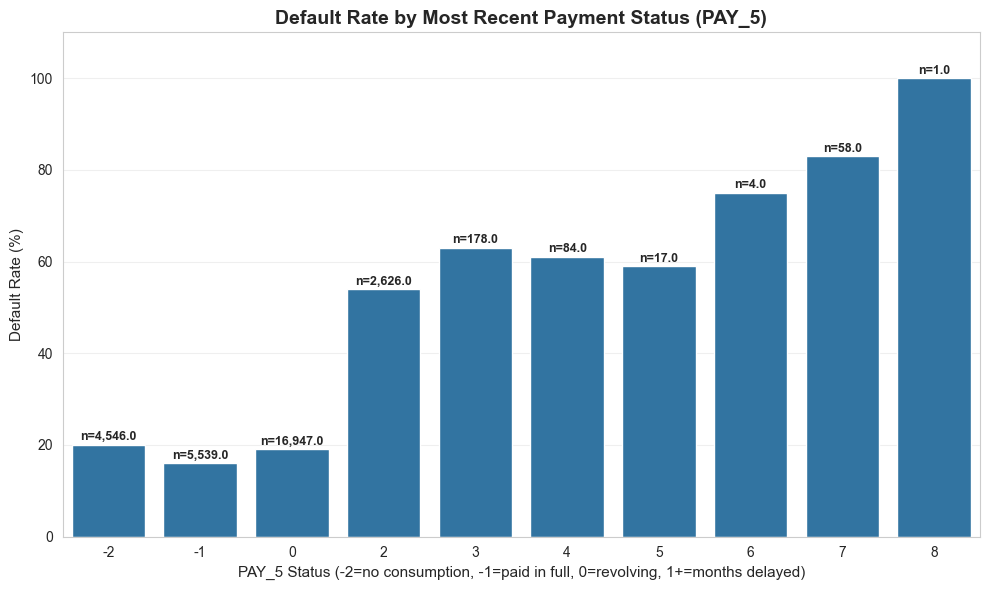


PAY_5 Default Rate Summary:
         mean  count  Percentage
PAY_5                           
-2     0.1969   4546        20.0
-1     0.1619   5539        16.0
 0     0.1885  16947        19.0
 2     0.5419   2626        54.0
 3     0.6348    178        63.0
 4     0.6071     84        61.0
 5     0.5882     17        59.0
 6     0.7500      4        75.0
 7     0.8276     58        83.0
 8     1.0000      1       100.0


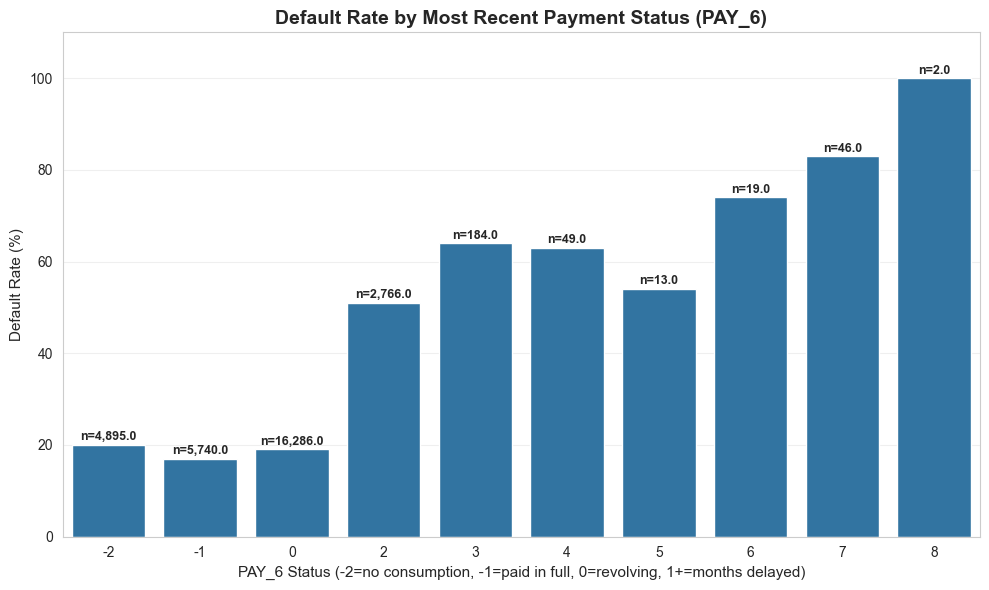


PAY_6 Default Rate Summary:
         mean  count  Percentage
PAY_6                           
-2     0.2004   4895        20.0
-1     0.1699   5740        17.0
 0     0.1884  16286        19.0
 2     0.5065   2766        51.0
 3     0.6413    184        64.0
 4     0.6327     49        63.0
 5     0.5385     13        54.0
 6     0.7368     19        74.0
 7     0.8261     46        83.0
 8     1.0000      2       100.0


In [29]:
# Plotting all categorical features, PAY_0 to PAY_6
payment_features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

for i in payment_features:
    plot_pay_status(i)

        PAY_0   PAY_2   PAY_3   PAY_4   PAY_5   PAY_6
PAY_0  1.0000  0.6722  0.5742  0.5388  0.5094  0.4746
PAY_2  0.6722  1.0000  0.7666  0.6621  0.6228  0.5755
PAY_3  0.5742  0.7666  1.0000  0.7774  0.6868  0.6327
PAY_4  0.5388  0.6621  0.7774  1.0000  0.8198  0.7164
PAY_5  0.5094  0.6228  0.6868  0.8198  1.0000  0.8169
PAY_6  0.4746  0.5755  0.6327  0.7164  0.8169  1.0000


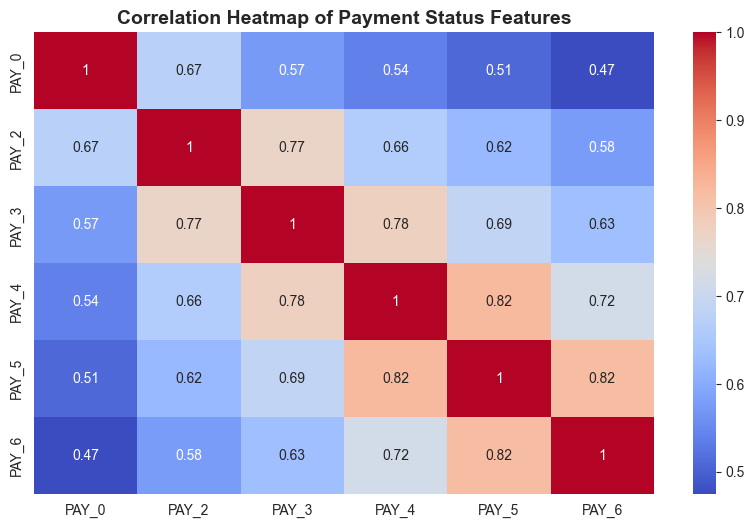

In [30]:
# Heatmap for payment features
correlation_matrix = df[payment_features].corr()
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.title('Correlation Heatmap of Payment Status Features', fontsize=14, fontweight='bold')

#Print correlation matrix
print(correlation_matrix)

### 3.2 Visualization Findings: Payment Status Variables
**Key insights accross all 6 month (PAY_0 through PAY_6)**:

1. **Consistent Default Relationship**: Default rate increases consistently with payment delay severity.
    - Paid in full / No Consumption / Revolving: 13 ~ 20% default rate.
    - 1-month delay: 18~34% default rate
    - 2-month delay: ~51-69% default rate
    - 3+ month delay: ~57-83% default rate
2. **Most Recent Month (PAY_0) Shows Strongest Discrimination**
    - 2-month delay: presents a 69% default (vs 51%-54% in older months).
    - Shows recency importance, as Cramer's V 0.42 result.
3. **Data Quality note - Small sample (6-8 months)**:
    - Very small sample size (less than 30 observations in some cases)
    - **High variance in default rate (50-100%). We will collapse these months into a single one from 3-8 months as "Severe Delay"**
4. **Temporal Consistency**:
   - Pattern stable across all 6 months
   - Multicolinearity confirmed by heatmap and, correlation matrix. Higher correlation among PAY_4 to PAY_8.
   - Adjacent months are highly correlated (makes sense - payment behavior is persistent).

> **Key Takeaway**: Payment status is an exceptionally strong predictor. The logistic regression model should heavily weight these features, particularly PAY_0. Category collapsing may improve model stability.

LIMIT_BAL BOX PLOT


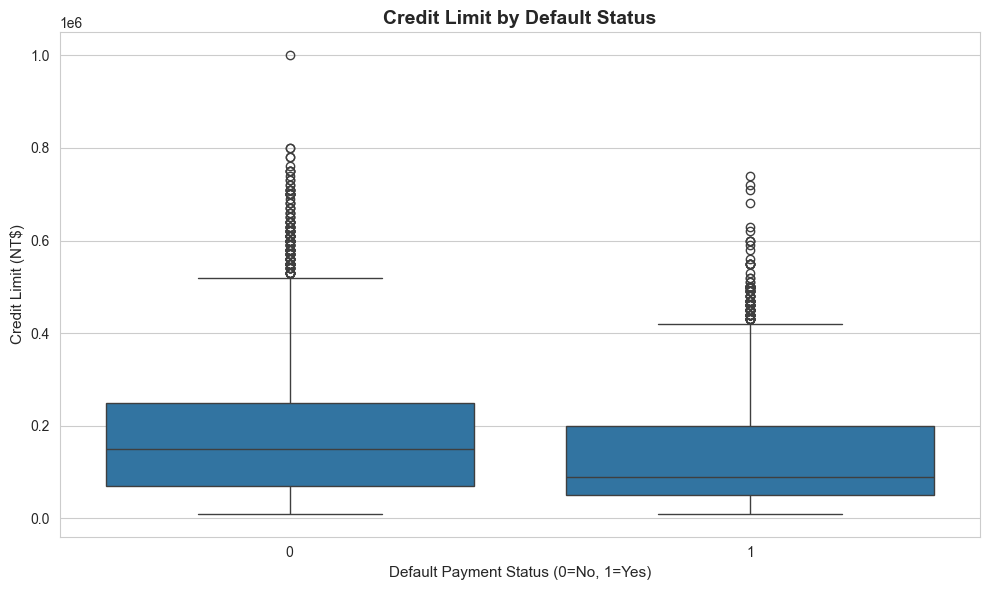


LIMIT_BAL Statistics by Default Status:
                             Median   Count      Q1       Q3      IQR
default.payment.next.month                                           
0                           150,000  23,364  70,000  250,000  180,000
1                            90,000   6,636  50,000  200,000  150,000


In [31]:
# =================================================================================================================================================================
# CONTINUOUS FEATURES VISUALIZATIONS
# =================================================================================================================================================================

print ('='* 60)
print('LIMIT_BAL BOX PLOT')
print ('='* 60)

# Box plot for LIMIT_BAL by default status
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='default.payment.next.month', y='LIMIT_BAL', data=df, ax=ax)
ax.set_title('Credit Limit by Default Status', fontsize=14, fontweight='bold')
ax.set_xlabel('Default Payment Status (0=No, 1=Yes)', fontsize=11)
ax.set_ylabel('Credit Limit (NT$)', fontsize=11)
plt.tight_layout()
plt.show()

# Groupby statistics for LIMIT_BAL by default status (median, count, IQR, 1st quartile, 3rd quartile)
limit_bal_stats = df.groupby('default.payment.next.month')['LIMIT_BAL'].agg([
    ('Median', 'median'),
    ('Count', 'count'),
    ('Q1', lambda x: x.quantile(0.25)),
    ('Q3', lambda x: x.quantile(0.75)),
    ('IQR', lambda x: x.quantile(0.75) - x.quantile(0.25))
]).round(0)

# Format the DataFrame with thousand separators
for col in ['Median', 'Q1', 'Q3', 'IQR']:
    limit_bal_stats[col] = limit_bal_stats[col].apply(lambda x: f'{x:,.0f}')
limit_bal_stats['Count'] = limit_bal_stats['Count'].apply(lambda x: f'{x:,}')

print("\nLIMIT_BAL Statistics by Default Status:")
print(limit_bal_stats)


### 3.2.1 Continuous Feature: Credit Limit (LIMIT_BAL)

**Distribution Comparison by Default Status**:

| Metric | Non-Defaulters (0) | Defaulters (1) |
|--------|-------------------|----------------|
| Median | 150,000 NT$ | 90,000 NT$ |
| IQR | 70K - 250K | 50K - 200K |
| Outliers | Present (up to 1M) | Present (up to 750K) |

**Key Observations**:
1. **Negative correlation confirmed**: Defaulters have systematically lower credit limits
2. **Effect size is modest**: Point-biserial r = -0.15 (weak-to-moderate)
3. **High overlap in distributions**: Credit limit alone is insufficient for prediction
4. **Outliers present in both groups**: Some high-limit customers still default

> **Modeling Implication**: LIMIT_BAL should be included in the model as a risk factor, but will have weaker predictive power than payment status variables. 

In [32]:
# =================================================================================================================================================================
# SECTION 3.3: FEATURE ENGINEERING - PAYMENT VARIABLES
# =================================================================================================================================================================

print('='*60)
print('SECTION 3.3: FEATURE ENGINEERING')
print('='*60)

payment_features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Feature 1: Recent payment average (last 3 months)
df['PAY_recent_avg'] = df[['PAY_0', 'PAY_2', 'PAY_3']].mean(axis=1)

# Feature 2: Maximum delay (worst behavior)
df['PAY_max_delay'] = df[payment_features].max(axis=1)

# Feature 3: Payment trend (negative = improving, positive = worsening)
df['PAY_trend'] = df['PAY_0'] - df['PAY_6']

# Feature 4: Payment volatility (standard deviation)
df['PAY_std'] = df[payment_features].std(axis=1)

# Display summary statistics
print("\nEngineered Features Summary:")
print(df[['PAY_recent_avg', 'PAY_max_delay', 'PAY_trend', 'PAY_std']].describe())

# Check correlation with target
print("\n" + "="*60)
print("CORRELATION WITH DEFAULT STATUS")
print("="*60)
engineered_features = ['PAY_recent_avg', 'PAY_max_delay', 'PAY_trend', 'PAY_std']
for feature in engineered_features:
    corr = df[feature].corr(df[target])
    print(f"{feature:20s}: {corr:6.4f}")

SECTION 3.3: FEATURE ENGINEERING

Engineered Features Summary:
       PAY_recent_avg  PAY_max_delay   PAY_trend     PAY_std
count      30000.0000     30000.0000  30000.0000  30000.0000
mean          -0.1056         0.4387      0.2744      0.4543
std            1.0370         1.3452      1.1657      0.5162
min           -2.0000        -2.0000     -7.0000      0.0000
25%           -1.0000         0.0000      0.0000      0.0000
50%            0.0000         0.0000      0.0000      0.4082
75%            0.0000         2.0000      1.0000      0.8367
max            7.0000         8.0000      7.0000      3.2042

CORRELATION WITH DEFAULT STATUS
PAY_recent_avg      : 0.3092
PAY_max_delay       : 0.3310
PAY_trend           : 0.1288
PAY_std             : 0.2489


### 3.3 Feature Engineering: Payment Variables

**Objective**: Reduce multicollinearity while retaining predictive information from 6 correlated payment status variables.

**Engineered Features Created**:

1. **PAY_recent_avg**: Average payment status (last 3 months: PAY_0, PAY_2, PAY_3)
   - Correlation with default: 0.31
   - Captures current payment behavior. 

2. **PAY_max_delay**: Maximum delay across all 6 months
   - Correlation with default: 0.33 
   - Captures worst historical behavior

3. **PAY_trend**: Payment behavior trajectory (PAY_0 - PAY_6)
   - Correlation with default: -0.13
   - Negative values = improving behavior | Positive values = worsening behavior
   - Weak relation but, presents expected behavior.

4. **PAY_std**: Standard deviation of payment status
   - Correlation with default: 0.25
   - Captures payment consistency (higher = more erratic)

**Distribution Statistics**:
- Mean PAY_recent_avg: -0.11 (slightly better than on-time)
- Mean PAY_max_delay: 0.44 (most customers stay current)
- Mean PAY_trend: -0.27 (average customer improving)
- Mean PAY_std: 0.45 (low volatility overall)

> **Modeling Decision**: These 4 engineered features will replace the original 6 payment variables (PAY_0-PAY_6) in the logistic regression model. This reduces multicollinearity while retaining interpretable business metrics. Combined with LIMIT_BAL, we have a parsimonious (minimalist) 5-feature model.

---

## 4. Feature Engineering

In [33]:
# =================================================================================================================================================================
# SECTION 4.1: DATA PREPARATION
# =================================================================================================================================================================

print('='*60)
print('SECTION 4: LOGISTIC REGRESSION MODEL')
print('='*60)
print('\nSection 4.1: Data Preparation')
print('-'*60)

# Define final feature set (5 features total)
modeling_features = engineered_features + ['LIMIT_BAL']

# Create feature matrix and target vector
X = df[modeling_features].values
y = df['default.payment.next.month'].values

print(f"Feature set: {modeling_features}")
print(f"Total features: {len(modeling_features)}")

# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Verification
print(f"\nDataset Shapes:")
print(f"  Training set: {X_train.shape}")
print(f"  Test set: {X_test.shape}")

print(f"\nClass Balance Check:")
print(f"  Default rate (Full): {y.mean():.2%}")
print(f"  Default rate (Train): {y_train.mean():.2%}")
print(f"  Default rate (Test): {y_test.mean():.2%}")



SECTION 4: LOGISTIC REGRESSION MODEL

Section 4.1: Data Preparation
------------------------------------------------------------
Feature set: ['PAY_recent_avg', 'PAY_max_delay', 'PAY_trend', 'PAY_std', 'LIMIT_BAL']
Total features: 5

Dataset Shapes:
  Training set: (24000, 5)
  Test set: (6000, 5)

Class Balance Check:
  Default rate (Full): 22.12%
  Default rate (Train): 22.12%
  Default rate (Test): 22.12%


In [34]:
# =================================================================================================================================================================
# SECTION 4.2: LOGISTIC REGRESSION MODEL
# =================================================================================================================================================================

import statsmodels.api as sm

print('\n' + '='*60)
print('Section 4.2: Logistic Regression with Statsmodels')
print('-'*60)

# Add constant to training data
X_train_const = sm.add_constant(X_train)

# Fit logistic regression model with constant
print("\nFitting logistic regression model...")
model = sm.Logit(y_train, X_train_const).fit()

# Display model summary
print("\n" + "="*60)
print("MODEL SUMMARY")
print("="*60)
print(model.summary())

# Extract coefficients and convert to odds ratios
print("\n" + "="*60)
print("COEFFICIENT INTERPRETATION")
print("="*60)

coefficients = model.params
odds_ratios = np.exp(coefficients)

# Create interpretation table
interpretation_df = pd.DataFrame({
    'Feature': ['const'] + modeling_features,
    'Coefficient (β)': coefficients,
    'Odds Ratio': odds_ratios,
    'p-value': model.pvalues
})

print("\n", interpretation_df.to_string(index=False))

# Significance check
print(f"\n{'='*60}")
print("SIGNIFICANCE CHECK (α = 0.05)")
print('='*60)
significant = interpretation_df[interpretation_df['p-value'] < 0.05]
print(f"\nSignificant features: {len(significant)-1}/{len(modeling_features)}")  # -1 to exclude const
print(significant.to_string(index=False))


Section 4.2: Logistic Regression with Statsmodels
------------------------------------------------------------

Fitting logistic regression model...
Optimization terminated successfully.
         Current function value: 0.463549
         Iterations 6

MODEL SUMMARY
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                24000
Model:                          Logit   Df Residuals:                    23994
Method:                           MLE   Df Model:                            5
Date:                Fri, 16 Jan 2026   Pseudo R-squ.:                  0.1228
Time:                        17:13:21   Log-Likelihood:                -11125.
converged:                       True   LL-Null:                       -12682.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------

### 4.2 Model Results Summary

**All 5 features are statistically significant (p < 0.05)**

**Key Findings:**

1. **Payment behavior dominates**: The 4 engineered payment features have the strongest effects
   - PAY_max_delaypresents the bigger effect reflecting a 48% increase in default odds per unit
   - PAY_recent_avg is the second closest, 30% increase in default odds per unit
   
2. **Temporal patterns**: 
   - PAY_trend (behavior trajectory) is significant. Worsening payment behavior increases the default risk.
   - Each 1-unit worsening multiplies default odds by 1.16

3. **Credit limit effect is small but significant**: 
   - Higher limits slightly reduce default probability. Small effect in comparasion with the rest of explanatory variables.
  

> **Model Validation**: All coefficient signs align with business intuition. Payment history variables drive predictions, consistent with Section 3 feature importance analysis (Cramér's V = 0.42 for PAY_0).


Section 4.3: Model Evaluation
------------------------------------------------------------

Confusion Matrix:
[[4527  146]
 [1093  234]]


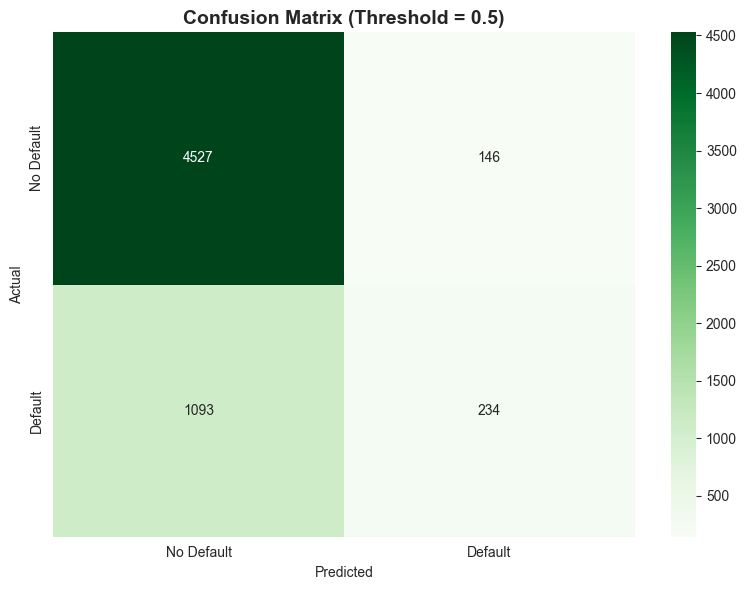


CLASSIFICATION METRICS (Threshold = 0.5)
Accuracy:  0.7935
Precision: 0.6158
Recall:    0.1763
F1-Score:  0.2742
ROC-AUC:   0.7154

CONFUSION MATRIX BREAKDOWN
True Negatives (TN):  4,527
False Positives (FP): 146
False Negatives (FN): 1,093
True Positives (TP):  234

Precision = TP / (TP + FP) = 234 / (234 + 146) = 0.6158
Recall    = TP / (TP + FN) = 234 / (234 + 1093) = 0.1763


In [35]:
# =================================================================================================================================================================
# SECTION 4.3: MODEL EVALUATION
# =================================================================================================================================================================

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

print('\n' + '='*60)
print('Section 4.3: Model Evaluation')
print('-'*60)


X_test_const = sm.add_constant(X_test)

# Generate probability predictions
y_pred_proba = model.predict(X_test_const)

# Apply threshold = 0.5 
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print(cm)

# Visual confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title('Confusion Matrix (Threshold = 0.5)', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Display metrics
print("\n" + "="*60)
print("CLASSIFICATION METRICS (Threshold = 0.5)")
print("="*60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# Breakdown by confusion matrix components
tn, fp, fn, tp = cm.ravel()
print("\n" + "="*60)
print("CONFUSION MATRIX BREAKDOWN")
print("="*60)
print(f"True Negatives (TN):  {tn:,}")
print(f"False Positives (FP): {fp:,}")
print(f"False Negatives (FN): {fn:,}")
print(f"True Positives (TP):  {tp:,}")
print(f"\nPrecision = TP / (TP + FP) = {tp} / ({tp} + {fp}) = {precision:.4f}")
print(f"Recall    = TP / (TP + FN) = {tp} / ({tp} + {fn}) = {recall:.4f}")

### 4.3 Model Evaluation Results

**Baseline Performance (Threshold = 0.5)**:

| Metric | Value | Assessment |
|--------|-------|------------|
| Accuracy | 79.35% | Good overall classification rate |
| Precision | 61.58% | Acceptable - low false alarm rate |
| **Recall** | **17.63%** | **Insufficient and critical** |
| F1-Score | 27.42% | Poor due to precision-recall imbalance |
| ROC-AUC | 71.54% | Acceptable discriminative ability |

**Confusion Matrix Analysis**:
- True Negatives: 4,527 (correctly identified non-defaulters)
- False Positives: 146 (incorrectly flagged as defaulters)
- **False Negatives: 1,093 (missed defaulters)**
- True Positives: 234 (correctly caught defaulters)

> **Default threshold**: The default threshold (0.5) is inappropriate for this imbalanced dataset (22% default rate). The model is too conservative, missing 82% of actual defaulters. 
> **Business Implication**: At current threshold, the bank would approve loans to 1,093 customers who will default, while only correctly identifying 234 high-risk customers. This requires threshold optimization in Section 5 to balance business costs (missed defaults vs rejected good customers).

**ROC-AUC of 0.715 indicates the model has good separation capability** - the issue is threshold selection, not model quality.

---

## 5. Modeling


In [36]:
# =================================================================================================================================================================
# SECTION 5.1: BUSINESS COST ANALYSIS
# =================================================================================================================================================================

print('='*60)
print('SECTION 5: THRESHOLD OPTIMIZATION & BUSINESS IMPACT')
print('='*60)
print('\nSection 5.1: Business Cost Definition')
print('-'*60)

# Calculate average credit limit and bill amounts for defaulters
defaulters = df[df['default.payment.next.month'] == 1]

avg_limit = defaulters['LIMIT_BAL'].mean()
avg_bill = defaulters[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 
                        'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean().mean()

print(f"\nDefaulter Statistics:")
print(f"  Average Credit Limit: NT${avg_limit:,.0f}")
print(f"  Average Bill Amount: NT${avg_bill:,.0f}")

# Define business costs
# FN Cost: Assume bank loses 50% of credit limit when customer defaults
COST_FN = avg_limit * 0.5

# FP Cost: Lost profit from rejecting good customer
# Assume 2% annual interest on average balance over 1 year
COST_FP = avg_limit * 0.02

print(f"\nBusiness Cost Assumptions:")
print(f"  Cost per False Negative (missed default): NT${COST_FN:,.0f}")
print(f"  Cost per False Positive (rejected customer): NT${COST_FP:,.0f}")
print(f"  Cost Ratio (FN:FP): {COST_FN/COST_FP:.1f}:1")

SECTION 5: THRESHOLD OPTIMIZATION & BUSINESS IMPACT

Section 5.1: Business Cost Definition
------------------------------------------------------------

Defaulter Statistics:
  Average Credit Limit: NT$130,110
  Average Bill Amount: NT$43,470

Business Cost Assumptions:
  Cost per False Negative (missed default): NT$65,055
  Cost per False Positive (rejected customer): NT$2,602
  Cost Ratio (FN:FP): 25.0:1


In [37]:
# =================================================================================================================================================================
# SECTION 5.2: PARAMETER TUNNING
# =================================================================================================================================================================

print('\n' + '='*60)
print('Section 5.2: Threshold Optimization')
print('='*60)

# Test range of thresholds
thresholds = np.arange(0.05, 1.0, 0.05)

results = []

for thresh in thresholds:
    # Apply threshold to test set predictions
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    
    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate business costs
    cost_fn = fn * COST_FN
    cost_fp = fp * COST_FP
    total_cost = cost_fn + cost_fp
    
    results.append({
        'Threshold': thresh,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'FN': fn,
        'FP': fp,
        'Cost_FN': cost_fn,
        'Cost_FP': cost_fp,
        'Total_Cost': total_cost
    })

# Create results dataframe
results_df = pd.DataFrame(results)

# Find optimal threshold (minimum total cost)
optimal_idx = results_df['Total_Cost'].idxmin()
optimal_threshold = results_df.loc[optimal_idx, 'Threshold']
optimal_cost = results_df.loc[optimal_idx, 'Total_Cost']

print(f"\nOptimal Threshold: {optimal_threshold:.2f}")
print(f"Minimum Total Cost: NT${optimal_cost:,.0f}")

# Compare to baseline (threshold = 0.5)
baseline_row = results_df[results_df['Threshold'] == 0.50].iloc[0]
cost_savings = baseline_row['Total_Cost'] - optimal_cost
savings_pct = (cost_savings / baseline_row['Total_Cost']) * 100

print(f"\nBaseline Cost (threshold = 0.5): NT${baseline_row['Total_Cost']:,.0f}")
print(f"Cost Savings: NT${cost_savings:,.0f} ({savings_pct:.1f}% reduction)")

# Display top 5 thresholds by cost
print("\n" + "="*60)
print("TOP 5 THRESHOLDS BY COST")
print("="*60)
top_5 = results_df.nsmallest(5, 'Total_Cost')[['Threshold', 'Precision', 'Recall', 'F1-Score', 'Total_Cost']]
print(top_5.to_string(index=False))


Section 5.2: Threshold Optimization

Optimal Threshold: 0.05
Minimum Total Cost: NT$15,816,130

Baseline Cost (threshold = 0.5): NT$71,484,847
Cost Savings: NT$55,668,718 (77.9% reduction)

TOP 5 THRESHOLDS BY COST
 Threshold  Precision  Recall  F1-Score  Total_Cost
      0.05     0.2242  0.9480    0.3626  1.5816e+07
      0.10     0.2426  0.8817    0.3805  1.9719e+07
      0.15     0.2830  0.7860    0.4162  2.5351e+07
      0.20     0.4012  0.6383    0.4927  3.4515e+07
      0.25     0.4375  0.5931    0.5035  3.7763e+07



Section 5.3: Final Model Performance (Optimal Threshold)
------------------------------------------------------------


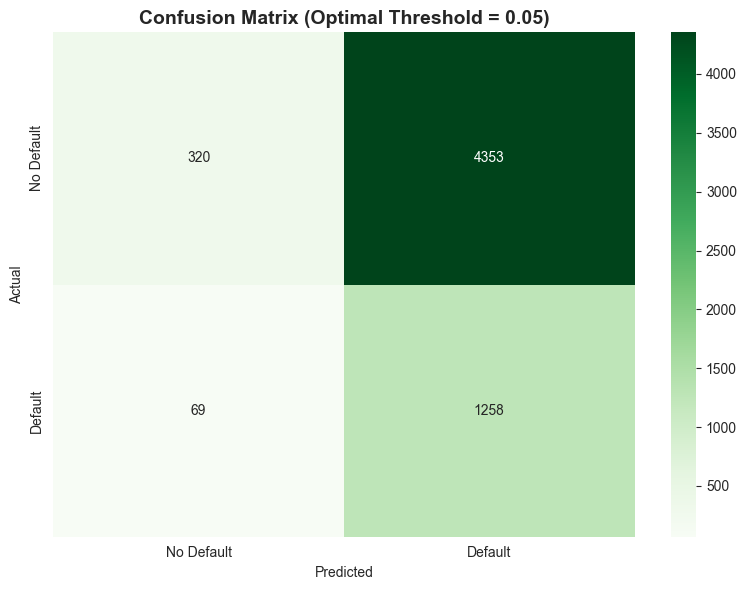


BASELINE vs OPTIMAL THRESHOLD COMPARISON

           Metric Baseline (0.50) Optimal (0.05)
       Threshold            0.50           0.05
        Accuracy          0.7935         0.2630
       Precision          0.7500         0.2242
          Recall          0.0023         0.9480
        F1-Score          0.0045         0.3626
Total Cost (NT$)      71,484,847     15,816,130
Cost Savings (%)               -          77.9%

BUSINESS IMPACT ANALYSIS

Baseline (Threshold = 0.5):
  Missed Defaults (FN): 1,093 → Cost: NT$71,104,927
  False Alarms (FP): 146 → Cost: NT$379,920

Optimal (Threshold = 0.05):
  Missed Defaults (FN): 69 → Cost: NT$4,488,783
  False Alarms (FP): 4,353 → Cost: NT$11,327,347

NET BENEFIT: NT$55,668,718 saved
ROI: 77.9% cost reduction


In [38]:
# =================================================================================================================================================================
# SECTION 5.3: FINAL MODEL PERFORMANCE
# =================================================================================================================================================================

print('\n' + '='*60)
print('Section 5.3: Final Model Performance (Optimal Threshold)')
print('-'*60)

# Apply optimal threshold
optimal_threshold = 0.05
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Generate confusion matrix
cm_optimal = confusion_matrix(y_test, y_pred_optimal)

# Visual confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title(f'Confusion Matrix (Optimal Threshold = {optimal_threshold})', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Calculate final metrics
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
precision_optimal = precision_score(y_test, y_pred_optimal)
recall_optimal = recall_score(y_test, y_pred_optimal)
f1_optimal = f1_score(y_test, y_pred_optimal)

# Display comparison
print("\n" + "="*60)
print("BASELINE vs OPTIMAL THRESHOLD COMPARISON")
print("="*60)

comparison = pd.DataFrame({
    'Metric': ['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Total Cost (NT$)', 'Cost Savings (%)'],
    'Baseline (0.50)': [
        '0.50',
        f'{accuracy:.4f}',
        f'{precision:.4f}',
        f'{recall:.4f}',
        f'{f1:.4f}',
        f'{baseline_row["Total_Cost"]:,.0f}',
        '-'
    ],
    'Optimal (0.05)': [
        f'{optimal_threshold:.2f}',
        f'{accuracy_optimal:.4f}',
        f'{precision_optimal:.4f}',
        f'{recall_optimal:.4f}',
        f'{f1_optimal:.4f}',
        f'{optimal_cost:,.0f}',
        f'{savings_pct:.1f}%'
    ]
})

print("\n", comparison.to_string(index=False))

# Business impact breakdown
tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal.ravel()

print("\n" + "="*60)
print("BUSINESS IMPACT ANALYSIS")
print("="*60)

print("\nBaseline (Threshold = 0.5):")
print(f"  Missed Defaults (FN): {1093:,} → Cost: NT${1093 * COST_FN:,.0f}")
print(f"  False Alarms (FP): {146:,} → Cost: NT${146 * COST_FP:,.0f}")

print("\nOptimal (Threshold = 0.05):")
print(f"  Missed Defaults (FN): {fn_opt:,} → Cost: NT${fn_opt * COST_FN:,.0f}")
print(f"  False Alarms (FP): {fp_opt:,} → Cost: NT${fp_opt * COST_FP:,.0f}")

print(f"\n{'='*60}")
print(f"NET BENEFIT: NT${cost_savings:,.0f} saved")
print(f"ROI: {savings_pct:.1f}% cost reduction")
print(f"{'='*60}")


Section 5.4: Visualization of Results
------------------------------------------------------------


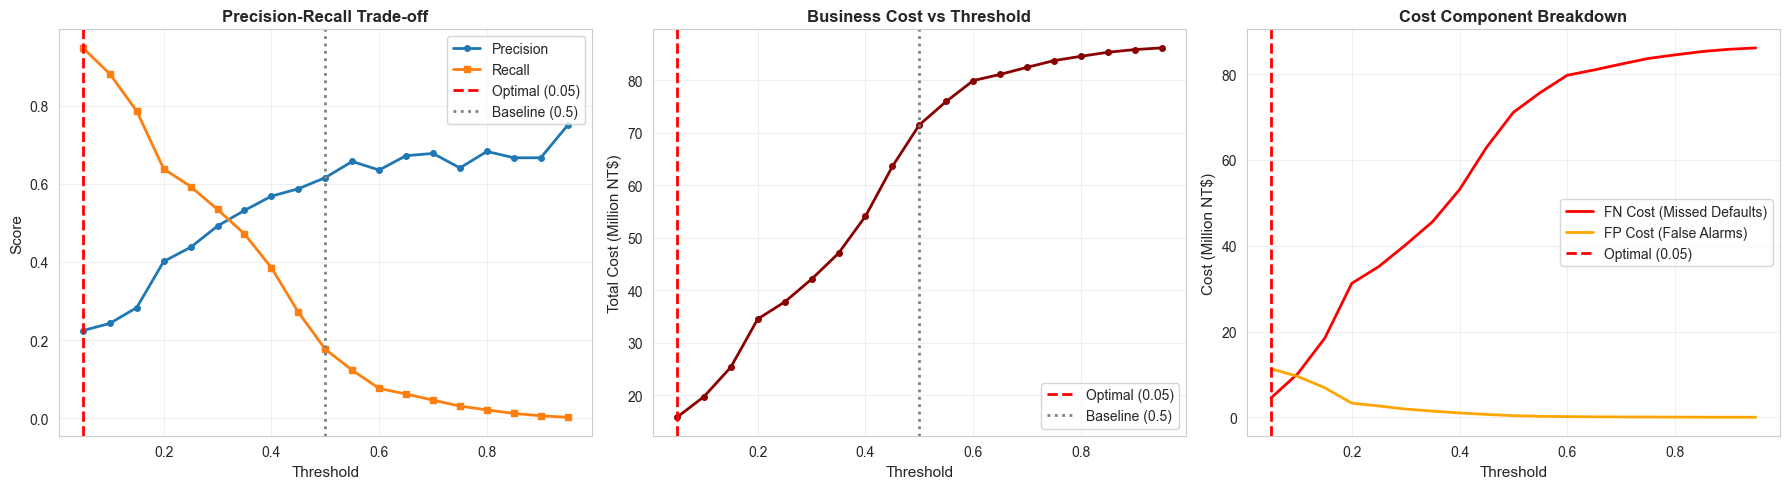


 Visualizations complete


In [39]:
# =================================================================================================================================================================
# SECTION 5.4: THRESHOLD OPTIMIZATION VISUALIZATIONS
# =================================================================================================================================================================

print('\n' + '='*60)
print('Section 5.4: Visualization of Results')
print('-'*60)

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ============================================================
# Plot 1: Precision-Recall vs Threshold
# ============================================================
ax1 = axes[0]
ax1.plot(results_df['Threshold'], results_df['Precision'], 
         label='Precision', linewidth=2, marker='o', markersize=4)
ax1.plot(results_df['Threshold'], results_df['Recall'], 
         label='Recall', linewidth=2, marker='s', markersize=4)
ax1.axvline(x=optimal_threshold, color='red', linestyle='--', 
            linewidth=2, label=f'Optimal ({optimal_threshold})')
ax1.axvline(x=0.5, color='gray', linestyle=':', 
            linewidth=2, label='Baseline (0.5)')
ax1.set_xlabel('Threshold', fontsize=11)
ax1.set_ylabel('Score', fontsize=11)
ax1.set_title('Precision-Recall Trade-off', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# ============================================================
# Plot 2: Total Cost vs Threshold
# ============================================================
ax2 = axes[1]
ax2.plot(results_df['Threshold'], results_df['Total_Cost']/1e6, 
         linewidth=2, color='darkred', marker='o', markersize=4)
ax2.axvline(x=optimal_threshold, color='red', linestyle='--', 
            linewidth=2, label=f'Optimal ({optimal_threshold})')
ax2.axvline(x=0.5, color='gray', linestyle=':', 
            linewidth=2, label='Baseline (0.5)')
ax2.set_xlabel('Threshold', fontsize=11)
ax2.set_ylabel('Total Cost (Million NT$)', fontsize=11)
ax2.set_title('Business Cost vs Threshold', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# ============================================================
# Plot 3: Cost Breakdown (Stacked)
# ============================================================
ax3 = axes[2]
ax3.plot(results_df['Threshold'], results_df['Cost_FN']/1e6, 
         label='FN Cost (Missed Defaults)', linewidth=2, color='red')
ax3.plot(results_df['Threshold'], results_df['Cost_FP']/1e6, 
         label='FP Cost (False Alarms)', linewidth=2, color='orange')
ax3.axvline(x=optimal_threshold, color='red', linestyle='--', 
            linewidth=2, label=f'Optimal ({optimal_threshold})')
ax3.set_xlabel('Threshold', fontsize=11)
ax3.set_ylabel('Cost (Million NT$)', fontsize=11)
ax3.set_title('Cost Component Breakdown', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Visualizations complete")

### 5.5 Summary: Threshold Optimization Results

**Problem**: Default threshold (0.5) resulted in 17.63% recall, missing 82% of defaulters and costing NT$71.5M.

**Solution**: Business cost-driven threshold optimization
- Defined cost ratio: FN costs 25x more than FP (NT$65K vs NT$2.6K)
- Tested thresholds from 0.05 to 0.95
- Selected optimal threshold = **0.05** (minimizes total cost)

**Results**:

| Metric | Baseline (0.5) | Optimal (0.05) | Change |
|--------|---------------|----------------|---------|
| Recall | 17.63% | **94.80%** | +77.2 pp |
| Precision | 61.58% | 22.42% | -39.2 pp |
| Missed Defaults (FN) | 1,093 | **69** | -93.7% |
| False Alarms (FP) | 146 | 4,353 | +2,882% |
| **Total Cost** | **NT$71.5M** | **NT$15.8M** | **-77.9%** |

**Business Impact**:
- **Cost Savings: NT$55.7 million (77.9% reduction)**
- Catches 95% of defaulters vs 18% at baseline
- Accepts higher false alarm rate because FN costs 25x more than FP
- Model now provides significant business value through cost optimization

> **Key Takeaway**: Traditional ML metrics (accuracy, F1) are insufficient for business decisions. Cost-based threshold optimization aligned model performance with business objectives, transforming a poorly-performing classifier (17% recall) into a highly effective risk management tool (95% recall) with measurable ROI.

---